# rt - detr finetuting

In [ ]:
!pip install -q --upgrade \
    git+https://github.com/huggingface/transformers.git \
    accelerate \
    roboflow \
    torchmetrics \
    "albumentations>=1.4.5" \
    git+https://github.com/roboflow/supervision.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [ ]:
import os
os.environ["ROBOFLOW_API_KEY"] = "#"
os.environ["WANDB_API_KEY"]  = "#"



In [ ]:
from roboflow import Roboflow
rf      = Roboflow(api_key=os.getenv("ROBOFLOW_API_KEY"))
proj    = rf.workspace("maritime-cumkb").project("singapore-maritime")
version = proj.version(1)
dataset = version.download("yolov5")
print("YOLO data at:", dataset.location)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Singapore-maritime-1 in yolov5pytorch:: 100%|██████████| 12712/12712 [00:04<00:00, 3056.86it/s]


YOLO data at: /content/Singapore-maritime-1


In [ ]:
import torch
from torch.utils.data import Dataset
import supervision as sv
from transformers import AutoImageProcessor, AutoModelForObjectDetection, TrainingArguments, Trainer

DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT = "PekingU/rtdetr_r18vd"

train_ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/train/images",
    annotations_directory_path=f"{dataset.location}/train/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)
valid_ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/valid/images",
    annotations_directory_path=f"{dataset.location}/valid/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

In [ ]:
processor = AutoImageProcessor.from_pretrained(CHECKPOINT)

class SimpleDataset(Dataset):
    def __init__(self, base_ds, processor):
        self.ds = base_ds
        self.processor = processor

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        _, image, anns = self.ds[idx]
        boxes = anns.xyxy
        labels = anns.class_id
        coco_annos = []
        for (x1, y1, x2, y2), cid in zip(boxes, labels):
            coco_annos.append({
                "image_id": idx,
                "category_id": int(cid),
                "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
                "area": float((x2 - x1) * (y2 - y1)),
                "iscrowd": 0
            })
        proc = self.processor(
            images=[image],
            annotations=[{"image_id": idx, "annotations": coco_annos}],
            return_tensors="pt"
        )
        pixel_values = proc["pixel_values"].squeeze(0)
        labels       = proc["labels"][0]
        return {"pixel_values": pixel_values, "labels": labels}

train_dataset = SimpleDataset(train_ds, processor)
valid_dataset = SimpleDataset(valid_ds, processor)

def collate_fn(batch):
    pixel_values = torch.stack([b["pixel_values"] for b in batch])
    labels       = [b["labels"] for b in batch]
    return {"pixel_values": pixel_values, "labels": labels}

preprocessor_config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
"""# ─── Cell 6: Model ve Trainer (Loss-only) ───
id2label = {i: c for i, c in enumerate(train_ds.classes)}
label2id = {c: i for i, c in enumerate(train_ds.classes)}
model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label               = id2label,
    label2id               = label2id,
    ignore_mismatched_sizes= True
).to(DEVICE)

training_args = TrainingArguments(
    output_dir                  = "rtdetr-yolo",
    num_train_epochs            = 20,
    per_device_train_batch_size = 16,         # veya 8
    learning_rate               = 5e-5,        # veya 2e-5
    eval_strategy         = "epoch",
    save_strategy               = "epoch",
    load_best_model_at_end      = True,
    logging_strategy            = "epoch",
    report_to                   = "none",
    save_total_limit            = 2,           # sadece en iyi 2 modeli tut
    warmup_ratio                = 0.1,         # stabil öğrenme için
    gradient_accumulation_steps= 1,
)

trainer = Trainer(
    model             = model,
    args              = training_args,
    train_dataset     = train_dataset,
    eval_dataset      = valid_dataset,
    data_collator     = collate_fn,
    processing_class  = processor
)"""

In [ ]:
"""id2label = {i: c for i, c in enumerate(train_ds.classes)}
label2id = {c: i for i, c in enumerate(train_ds.classes)}
model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label               = id2label,
    label2id               = label2id,
    ignore_mismatched_sizes= True
).to(DEVICE)


training_args = TrainingArguments(
    output_dir="rtdetr-yolo-v2",
    num_train_epochs=35,
    per_device_train_batch_size=24,          # VRAM yetmezse 12 + grad_acc=2
    gradient_accumulation_steps=1,
    learning_rate=3e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    weight_decay=0.05,
    eval_strategy="epoch",
    load_best_model_at_end=True,
    save_strategy="epoch",
    logging_strategy="epoch",
    fp16=True,
    save_total_limit=1,
)

trainer = Trainer(
    model             = model,
    args              = training_args,
    train_dataset     = train_dataset,
    eval_dataset      = valid_dataset,
    data_collator     = collate_fn,
    processing_class  = processor
    )"""

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r18vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([9]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([9]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([9]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- model.denoising_

'training_args = TrainingArguments(\n    output_dir="rtdetr-yolo-v2",\n    num_train_epochs=35,\n    per_device_train_batch_size=24,          # VRAM yetmezse 12 + grad_acc=2\n    gradient_accumulation_steps=1,\n    learning_rate=3e-5,\n    lr_scheduler_type="cosine",\n    warmup_ratio=0.05,\n    weight_decay=0.05,\n    eval_strategy="epoch",\n    load_best_model_at_end=True,\n    save_strategy="epoch",\n    logging_strategy="epoch",\n    fp16=True,\n    save_total_limit=1,\n)\n\ntrainer = Trainer(\n    model             = model,\n    args              = training_args,\n    train_dataset     = train_dataset,\n    eval_dataset      = valid_dataset,\n    data_collator     = collate_fn,\n    processing_class  = processor\n    )'

In [ ]:
from transformers import TrainingArguments, EarlyStoppingCallback

id2label = {i: c for i, c in enumerate(train_ds.classes)}
label2id = {c: i for i, c in enumerate(train_ds.classes)}
model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label               = id2label,
    label2id               = label2id,
    ignore_mismatched_sizes= True
).to(DEVICE)

training_args = TrainingArguments(
    output_dir="rtdetr-yolo-v3",
    num_train_epochs=40,
    per_device_train_batch_size=24,
    gradient_accumulation_steps=1,
    learning_rate=7.5e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    weight_decay=0.02,                        # WD yumuşatıldı
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_strategy="epoch",
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    processing_class=processor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)],
)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/80.9M [00:00<?, ?B/s]

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r18vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([9]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([9]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([9]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([9, 256]) in the model instantiated
- model.denoising_

In [ ]:
# ─── Cell 7: Eğitimi Başlat ───
trainer.train()

wandb: Currently logged in as: wewidi2538 (cookieai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,20.829400,6.008470
2,8.234800,4.346856
3,6.494700,3.710197
4,5.668400,3.289538


Epoch,Training Loss,Validation Loss
1,20.829400,6.008470
2,8.234800,4.346856
3,6.494700,3.710197
4,5.668400,3.289538
5,5.237400,3.079627
6,4.881300,3.003476
7,4.641800,2.684575
8,4.441300,2.655832
9,4.275500,2.550842
10,4.187100,2.558346


There were missing keys in the checkpoint model loaded: ['class_embed.0.weight', 'class_embed.0.bias', 'class_embed.1.weight', 'class_embed.1.bias', 'class_embed.2.weight', 'class_embed.2.bias', 'bbox_embed.0.layers.0.weight', 'bbox_embed.0.layers.0.bias', 'bbox_embed.0.layers.1.weight', 'bbox_embed.0.layers.1.bias', 'bbox_embed.0.layers.2.weight', 'bbox_embed.0.layers.2.bias', 'bbox_embed.1.layers.0.weight', 'bbox_embed.1.layers.0.bias', 'bbox_embed.1.layers.1.weight', 'bbox_embed.1.layers.1.bias', 'bbox_embed.1.layers.2.weight', 'bbox_embed.1.layers.2.bias', 'bbox_embed.2.layers.0.weight', 'bbox_embed.2.layers.0.bias', 'bbox_embed.2.layers.1.weight', 'bbox_embed.2.layers.1.bias', 'bbox_embed.2.layers.2.weight', 'bbox_embed.2.layers.2.bias'].


TrainOutput(global_step=7440, training_loss=4.112205607916719, metrics={'train_runtime': 17242.2904, 'train_samples_per_second': 10.312, 'train_steps_per_second': 0.431, 'total_flos': 2.632370632851456e+19, 'train_loss': 4.112205607916719, 'epoch': 40.0})

In [ ]:
import torch
import numpy as np
from transformers import AutoModelForObjectDetection, AutoImageProcessor
from supervision import Detections
from supervision.metrics.mean_average_precision import MeanAveragePrecision

device         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_dir = "/content/rtdetr-yolo-v3/checkpoint-7440" # best

model     = AutoModelForObjectDetection.from_pretrained(
    checkpoint_dir,
    ignore_mismatched_sizes=True,
).to(device)
model.eval()

processor = AutoImageProcessor.from_pretrained(checkpoint_dir)

metric    = MeanAveragePrecision()

preds_list = []
targs_list = []


THRESHOLD = 0.3   #hocam burayi 0.5 de yapabiliriz.

for idx in range(len(valid_dataset)):
    item = valid_dataset[idx]
    img_tensor = item["pixel_values"].unsqueeze(0).to(device)
    labs       = item["labels"]
    H, W       = img_tensor.shape[-2], img_tensor.shape[-1]


    gt_rel     = labs["boxes"].cpu().numpy()              # [N,4]: [cx_rel,cy_rel,w_rel,h_rel]
    gt_wh      = gt_rel[:, 2:] * np.array([W, H])         # [w_px, h_px]
    gt_xy      = gt_rel[:, :2] * np.array([W, H])         # [cx_px, cy_px]
    x0 = gt_xy[:,0] - gt_wh[:,0]/2
    y0 = gt_xy[:,1] - gt_wh[:,1]/2
    x1 = gt_xy[:,0] + gt_wh[:,0]/2
    y1 = gt_xy[:,1] + gt_wh[:,1]/2
    gt_boxes_px = np.stack([x0, y0, x1, y1], axis=1)
    gt_labels   = labs["class_labels"].cpu().numpy()


    with torch.no_grad():
        outputs = model(img_tensor)
    res = processor.post_process_object_detection(
        outputs,
        threshold=THRESHOLD,
        target_sizes=[(H, W)]
    )[0]

    pred_boxes  = res["boxes"].cpu().numpy()
    pred_scores = res["scores"].cpu().numpy()
    pred_labels = res["labels"].cpu().numpy()


    det_pred = Detections(xyxy=pred_boxes,
                          confidence=pred_scores,
                          class_id=pred_labels)
    det_targ = Detections(xyxy=gt_boxes_px,
                          class_id=gt_labels)

    preds_list.append(det_pred)
    targs_list.append(det_targ)


metric.update(preds_list, targs_list)
result = metric.compute()

print(f"mAP@50:    {result.map50:.4f}")
print(f"mAP@50-95: {result.map50_95:.4f}")


mAP@50:    0.9345
mAP@50-95: 0.7820


In [ ]:
from google.colab import drive
from pathlib import Path
import shutil
import zipfile
import os

drive.mount("/content/drive", force_remount=True)

drive_target_base = Path("/content/rtdetr-yolo-v4")
drive_target_base.mkdir(parents=True, exist_ok=True)

best_ckpt = getattr(trainer.state, "best_model_checkpoint", None)
if best_ckpt:
    print(f"Best checkpoint detected: {best_ckpt}")
    src = Path(best_ckpt)
    dst = drive_target_base / src.name
    shutil.copytree(src, dst, dirs_exist_ok=True)
    trainer.save_model(drive_target_base / "final_best_model")  # model + config
    processor.save_pretrained(drive_target_base / "final_best_model")
else:
    print("Best checkpoint bulunamadı; tüm output_dir ('rtdetr-yolo') kopyalanıyor.")
    shutil.copytree("rtdetr-yolo", drive_target_base / "full_output", dirs_exist_ok=True)
    trainer.save_model(drive_target_base / "final_best_model")
    processor.save_pretrained(drive_target_base / "final_best_model")

zip_path = drive_target_base / "best_model_archive.zip"
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    to_zip = drive_target_base / "final_best_model"
    for root, _, files in os.walk(to_zip):
        for f in files:
            full_path = Path(root) / f
            zf.write(full_path, arcname=full_path.relative_to(drive_target_base))
print(f"En iyi model Drive'a kopyalandı ve arşivlendi: {zip_path}")


Mounted at /content/drive
Best checkpoint detected: rtdetr-yolo-v3/checkpoint-7440
En iyi model Drive'a kopyalandı ve arşivlendi: /content/rtdetr-yolo-v4/best_model_archive.zip



--- Örnek 51 ---


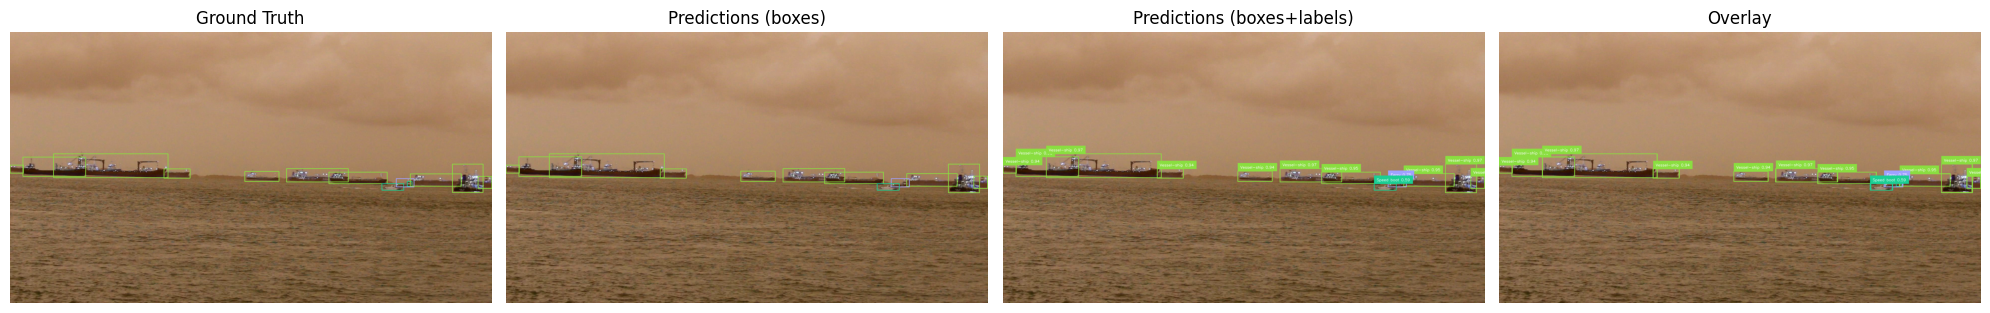

IoU matrisi (GT x Pred):
 [[0.   0.   0.   0.   0.   0.   0.   0.98 0.   0.   0.   0.  ]
 [1.   0.   0.19 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.19 0.   0.99 0.   0.   0.   0.   0.   0.   0.01 0.   0.  ]
 [0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.98 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.98 0.   0.   0.  ]
 [0.   0.   0.   0.98 0.   0.   0.15 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.15 0.   0.   0.97 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.11 0.93]
 [0.   0.   0.   0.   0.   0.03 0.   0.   0.   0.   0.89 0.08]
 [0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.15 0.  ]
 [0.   0.08 0.   0.   0.   0.97 0.   0.   0.   0.   0.03 0.  ]
 [0.   0.97 0.   0.   0.07 0.08 0.   0.   0.   0.   0.   0.  ]
 [0.   0.07 0.   0.   0.98 0.   0.   0.   0.   0.   0.   0.  ]]
GT kutu sayısı: 13, Tahmin sayısı: 12
IoU >= 0.5 ile eşleşen kutu sayısı (baseline): 12

--- Örnek 563 ---


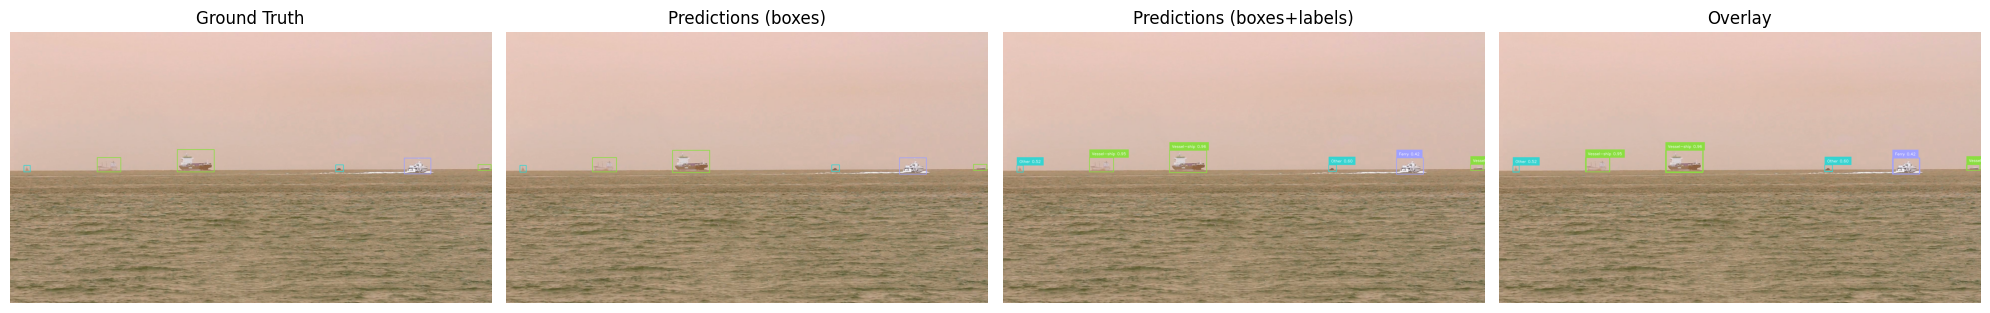

IoU matrisi (GT x Pred):
 [[0.   0.   0.   0.   0.93 0.  ]
 [0.   0.95 0.   0.   0.   0.  ]
 [0.   0.   0.95 0.   0.   0.  ]
 [0.   0.   0.   0.93 0.   0.  ]
 [0.91 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.94]]
GT kutu sayısı: 6, Tahmin sayısı: 6
IoU >= 0.5 ile eşleşen kutu sayısı (baseline): 6

--- Örnek 501 ---


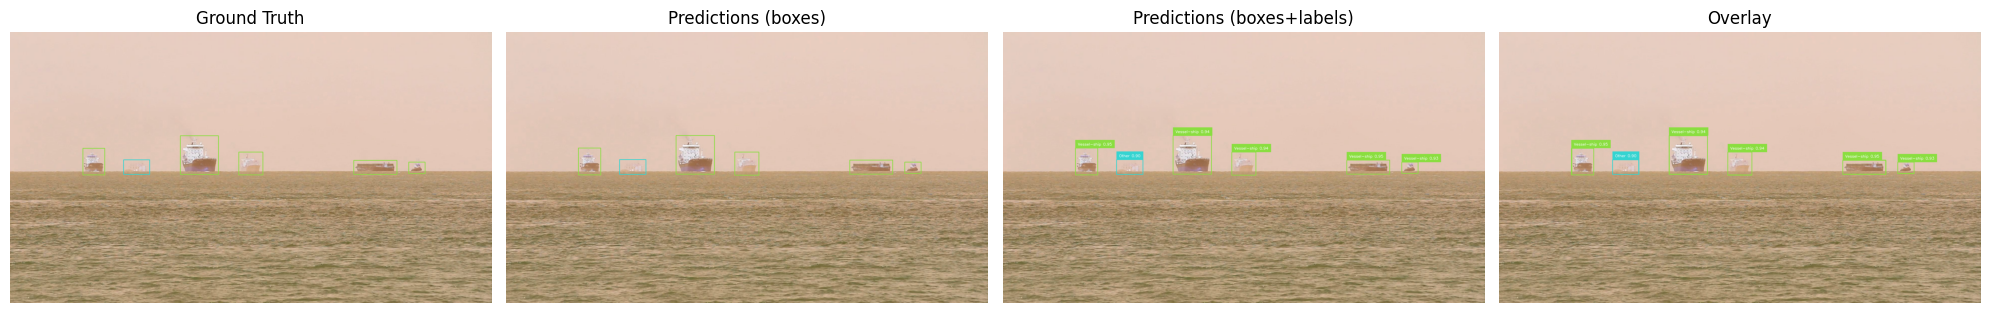

IoU matrisi (GT x Pred):
 [[0.96 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.97]
 [0.   0.   0.98 0.   0.   0.  ]
 [0.   0.   0.   0.99 0.   0.  ]
 [0.   0.96 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.96 0.  ]]
GT kutu sayısı: 6, Tahmin sayısı: 6
IoU >= 0.5 ile eşleşen kutu sayısı (baseline): 6

--- Örnek 457 ---


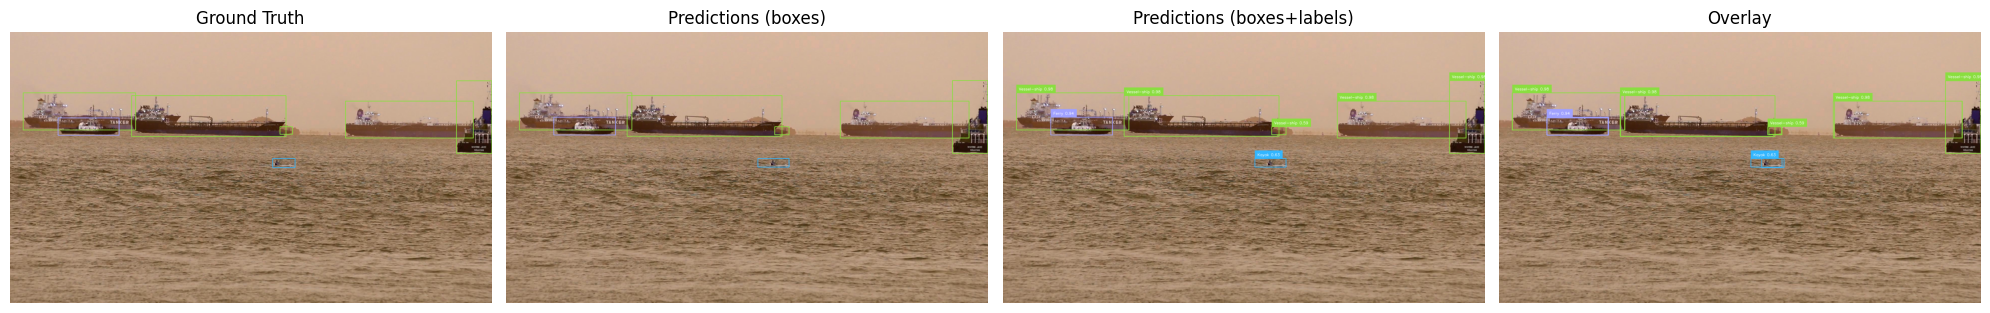

IoU matrisi (GT x Pred):
 [[0.   0.   0.02 0.99 0.18 0.   0.  ]
 [0.   0.   0.99 0.01 0.   0.   0.01]
 [0.   0.   0.01 0.   0.   0.   0.84]
 [0.   0.   0.   0.17 0.94 0.   0.  ]
 [0.   0.   0.   0.   0.   0.59 0.  ]
 [0.98 0.09 0.   0.   0.   0.   0.  ]
 [0.09 0.99 0.   0.   0.   0.   0.  ]]
GT kutu sayısı: 7, Tahmin sayısı: 7
IoU >= 0.5 ile eşleşen kutu sayısı (baseline): 7

--- Örnek 285 ---


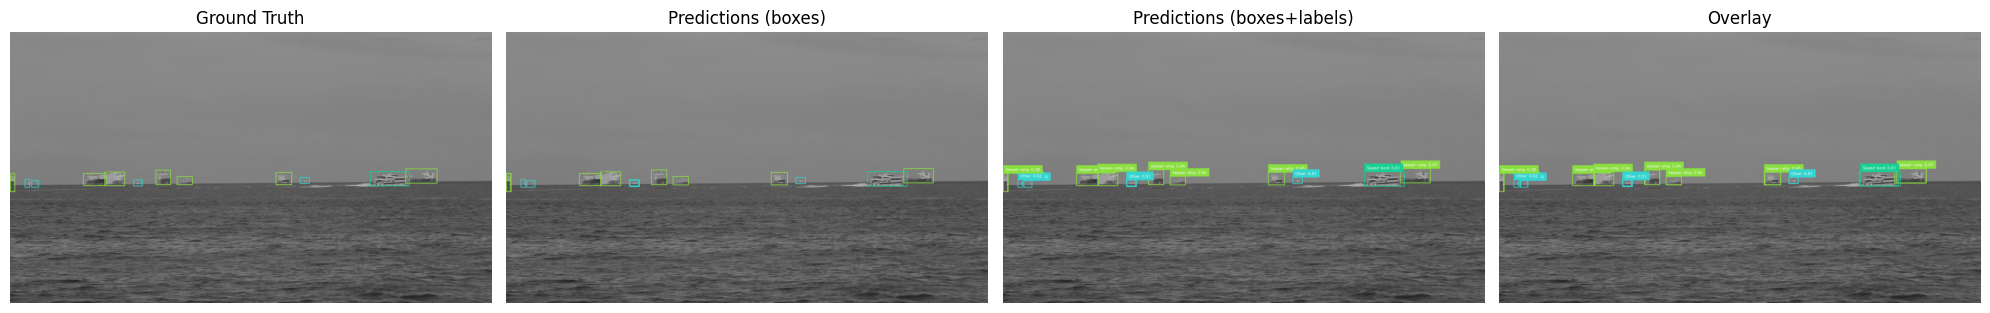

IoU matrisi (GT x Pred):
 [[0.   0.   0.   0.   0.   0.   0.95 0.   0.   0.   0.   0.   0.   0.86]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.96 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.86 0.   0.   0.   0.   0.  ]
 [0.   0.97 0.   0.   0.03 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.02 0.   0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.91 0.   0.   0.77 0.  ]
 [0.   0.   0.   0.96 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.96 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.94 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.95 0.   0.   0.   0.   0.   0.  ]
 [0.91 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.07 0.   0.  ]
 [0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.91 0.   0.  ]]
GT kutu sayısı: 12, Tahmin sayısı: 14
IoU >= 0.5 ile eşleşen kutu sayısı (baseline): 14


In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import supervision as sv
from supervision import Detections, BoxAnnotator, LabelAnnotator

# Modelı yükle (best checkpoint varsa)
best_ckpt = getattr(trainer.state, "best_model_checkpoint", None)
if best_ckpt:
    model = AutoModelForObjectDetection.from_pretrained(
        best_ckpt,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
    ).to(DEVICE)
    processor = AutoImageProcessor.from_pretrained(best_ckpt)
else:
    print("Best checkpoint yok; mevcut model kullanılıyor.")
    model.eval()

# Annotator’lar
box_annotator = sv.BoxAnnotator()              # kutuları çizer
label_annotator = sv.LabelAnnotator()          # metin etiketlerini ekler

# IoU hesaplama (GT x Pred)
def compute_iou_matrix(boxes1, boxes2):
    area1 = (boxes1[:,2]-boxes1[:,0]) * (boxes1[:,3]-boxes1[:,1])
    area2 = (boxes2[:,2]-boxes2[:,0]) * (boxes2[:,3]-boxes2[:,1])
    iou = np.zeros((len(boxes1), len(boxes2)))
    for i in range(len(boxes1)):
        for j in range(len(boxes2)):
            xA = max(boxes1[i,0], boxes2[j,0])
            yA = max(boxes1[i,1], boxes2[j,1])
            xB = min(boxes1[i,2], boxes2[j,2])
            yB = min(boxes1[i,3], boxes2[j,3])
            interW = max(0, xB - xA)
            interH = max(0, yB - yA)
            interArea = interW * interH
            union = area1[i] + area2[j] - interArea
            iou[i,j] = interArea / union if union > 0 else 0
    return iou

def visualize_sample(idx, threshold=0.3):
    # Orijinal görüntü + GT
    _, orig_image, anns = valid_ds[idx]
    H, W = orig_image.shape[0], orig_image.shape[1]

    # Model input
    item = valid_dataset[idx]
    img_tensor = item["pixel_values"].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = model(img_tensor)
    res = processor.post_process_object_detection(
        outputs,
        threshold=threshold,
        target_sizes=[(H, W)]
    )[0]

    pred_boxes  = res["boxes"].cpu().numpy()
    pred_scores = res["scores"].cpu().numpy()
    pred_labels = res["labels"].cpu().numpy()

    gt_boxes  = anns.xyxy
    gt_labels = anns.class_id

    # Detections objeleri
    det_pred = Detections(xyxy=pred_boxes,
                          confidence=pred_scores,
                          class_id=pred_labels)
    det_gt = Detections(xyxy=gt_boxes,
                        class_id=gt_labels)

    # Tahmin etiket metinleri (class + score)
    pred_class_names = [model.config.id2label.get(int(c), str(c)) for c in pred_labels]
    pred_label_texts = [f"{name} {score:.2f}" for name, score in zip(pred_class_names, pred_scores)]

    # Görselleri hazırla
    img_gt_only = box_annotator.annotate(scene=orig_image.copy(), detections=det_gt)
    img_pred_boxes = box_annotator.annotate(scene=orig_image.copy(), detections=det_pred)
    img_pred_full = label_annotator.annotate(
        scene=img_pred_boxes.copy(),
        detections=det_pred,
        labels=pred_label_texts
    )
    # Overlay: hem GT hem tahmin
    overlay = orig_image.copy()
    overlay = box_annotator.annotate(scene=overlay, detections=det_gt)
    overlay = box_annotator.annotate(scene=overlay, detections=det_pred)  # tahmin kutuları da üstüne
    overlay = label_annotator.annotate(
        scene=overlay,
        detections=det_pred,
        labels=pred_label_texts
    )

    # Göster
    fig, axes = plt.subplots(1, 4, figsize=(20,5))
    axes[0].imshow(img_gt_only);   axes[0].set_title("Ground Truth"); axes[0].axis("off")
    axes[1].imshow(img_pred_boxes); axes[1].set_title("Predictions (boxes)");  axes[1].axis("off")
    axes[2].imshow(img_pred_full);  axes[2].set_title("Predictions (boxes+labels)"); axes[2].axis("off")
    axes[3].imshow(overlay);        axes[3].set_title("Overlay");             axes[3].axis("off")
    plt.tight_layout()
    plt.show()

    # IoU ve eşleşmeler
    if len(gt_boxes) > 0 and len(pred_boxes) > 0:
        iou_mat = compute_iou_matrix(gt_boxes, pred_boxes)
        print("IoU matrisi (GT x Pred):\n", np.round(iou_mat, 2))
        matches = iou_mat >= 0.5
        tp = matches.sum()
        print(f"GT kutu sayısı: {len(gt_boxes)}, Tahmin sayısı: {len(pred_boxes)}")
        print(f"IoU >= 0.5 ile eşleşen kutu sayısı (baseline): {tp}")
    else:
        print(f"GT veya prediction yok (GT: {len(gt_boxes)}, Pred: {len(pred_boxes)})")

# Rastgele birkaç örnek çalıştır
num_samples = min(5, len(valid_dataset))
sample_idxs = random.sample(range(len(valid_dataset)), k=num_samples)
for i in sample_idxs:
    print(f"\n--- Örnek {i} ---")
    visualize_sample(i, threshold=0.3)


In [ ]:
# 1) Gerekli kütüphaneleri yükleyin
!pip install -U pip
!pip install torch torchvision transformers pillow torch_tensorrt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 58.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
INFO: pip is looking at multiple versions of torch-tensorrt to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 5.0 MB/s  0:00:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.9 MB/s  0:00:00
  DEPRECATION: Building 'tensorrt' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep5

In [ ]:
import torch
import time
import cv2
import numpy as np
from pathlib import Path
from transformers import (
    RTDetrForObjectDetection,
    RTDetrImageProcessor,
    AutoModelForObjectDetection,
    AutoImageProcessor,
)

# ----------- AYARLAR -----------
CHECKPOINT_DIR = "/content/rtdetr-yolo/checkpoint-5560"  # senin en iyi checkpoint klasörün
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# RT-DETR örneğindeki giriş boyutları (1080p padded to 1088)
TARGET_H, TARGET_W = 1080, 1920
PAD_HEIGHT = 1088  # 32 ile bölünebilir olması önemli

# TensorRT ayarları
USE_FP16 = True  # önce FP16 dene, olmazsa FP32 fallback
# ------------------------------

# -------- Model & processor yükle (RTDETR ise özel, değilse generic) -----------
using_rtdetr = False
try:
    processor = RTDetrImageProcessor.from_pretrained(CHECKPOINT_DIR)
    model_fp32 = RTDetrForObjectDetection.from_pretrained(CHECKPOINT_DIR).to(DEVICE).eval()
    using_rtdetr = True
    print("[INFO] RT-DETR modeli ve processor yüklendi.")
except Exception as e:
    print(f"[WARN] RTDetr yüklemesi başarısız ({e}), AutoModel/AutoProcessor’a geçiliyor.")
    processor = AutoImageProcessor.from_pretrained(CHECKPOINT_DIR)
    model_fp32 = AutoModelForObjectDetection.from_pretrained(
        CHECKPOINT_DIR, ignore_mismatched_sizes=True
    ).to(DEVICE).eval()

id2label = model_fp32.config.id2label  # fine-tuned sınıf eşlemesi

# -------- TensorRT compile (fallback ile) -----------
model = model_fp32  # default
use_fp16 = False
try:
    import torch_tensorrt

    input_shape = [1, 3, PAD_HEIGHT, TARGET_W]
    # FP16 denemesi
    if USE_FP16:
        try:
            trt_model = torch_tensorrt.compile(
                model_fp32,
                inputs=[
                    torch_tensorrt.Input(
                        min_shape=input_shape,
                        opt_shape=input_shape,
                        max_shape=input_shape,
                        dtype=torch.float16,
                    )
                ],
                enabled_precisions={torch.float16},
                workspace_size=1 << 28,
            )
            model = trt_model
            use_fp16 = True
            print("[INFO] TensorRT FP16 engine başarıyla derlendi.")
        except Exception as e_fp16:
            print(f"[WARN] FP16 derleme başarısız ({e_fp16}), FP32’e geçiliyor.")
            trt_model = torch_tensorrt.compile(
                model_fp32,
                inputs=[
                    torch_tensorrt.Input(
                        min_shape=input_shape,
                        opt_shape=input_shape,
                        max_shape=input_shape,
                        dtype=torch.float32,
                    )
                ],
                enabled_precisions={torch.float32},
                workspace_size=1 << 28,
            )
            model = trt_model
            use_fp16 = False
            print("[INFO] TensorRT FP32 engine başarıyla derlendi.")
    else:
        trt_model = torch_tensorrt.compile(
            model_fp32,
            inputs=[
                torch_tensorrt.Input(
                    min_shape=input_shape,
                    opt_shape=input_shape,
                    max_shape=input_shape,
                    dtype=torch.float32,
                )
            ],
            enabled_precisions={torch.float32},
            workspace_size=1 << 28,
        )
        model = trt_model
        use_fp16 = False
        print("[INFO] TensorRT FP32 engine başarıyla derlendi.")
except ImportError:
    print("[ERROR] torch_tensorrt yüklü değil; native model ile devam ediliyor.")
    model = model_fp32
    use_fp16 = False

# -------- Yardımcı fonksiyonlar --------
def extract_detections(outputs, processor, id2label, threshold=0.3, target_size=(TARGET_H, TARGET_W)):
    det = processor.post_process_object_detection(
        outputs,
        threshold=threshold,
        target_sizes=[target_size],
    )[0]
    classes = [id2label[int(l)] for l in det["labels"]]
    confidences = [float(s) for s in det["scores"]]
    bboxes = [[int(x) for x in box] for box in det["boxes"]]
    return classes, confidences, bboxes

def process_and_draw(frame, threshold=0.3):
    resized = cv2.resize(frame, (TARGET_W, TARGET_H))
    pad_total = PAD_HEIGHT - TARGET_H
    pad_top = pad_total // 2
    pad_bot = pad_total - pad_top
    padded = cv2.copyMakeBorder(
        resized, pad_top, pad_bot, 0, 0, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0)
    )
    rgb = cv2.cvtColor(padded, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    tensor = torch.from_numpy(rgb).permute(2, 0, 1).unsqueeze(0).to(DEVICE)
    tensor = tensor.half() if use_fp16 else tensor.float()

    torch.cuda.synchronize()
    t0 = time.time()
    with torch.no_grad():
        outputs = model(tensor)
    torch.cuda.synchronize()
    inf_time = time.time() - t0

    classes, confidences, bboxes = extract_detections(
        outputs, processor, id2label, threshold=threshold, target_size=(TARGET_H, TARGET_W)
    )
    # Görselleştir
    for cls, conf, (x0, y0, x1, y1) in zip(classes, confidences, bboxes):
        cv2.rectangle(resized, (x0, y0), (x1, y1), (0, 255, 0), 2)
        cv2.putText(
            resized,
            f"{cls} {conf:.2f}",
            (x0, max(y0 - 5, 0)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 255, 0),
            1,
        )
    return resized, inf_time, classes, confidences, bboxes

# -------- Örnek kullanım: tek bir görüntü üzerinde ----------
def infer_on_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise RuntimeError(f"Görüntü bulunamadı: {image_path}")
    out_img, t, classes, scores, boxes = process_and_draw(image)
    print(f"Inference süresi: {t*1000:.1f} ms, tespitler: {list(zip(classes, scores))}")
    cv2.imwrite("inference_result.jpg", out_img)
    print("[INFO] Sonuç görüntüsü kaydedildi: inference_result.jpg")


[INFO] RT-DETR modeli ve processor yüklendi.


[INFO] TensorRT FP16 engine başarıyla derlendi.


In [ ]:
import torch_tensorrt

# trt_model: torch_tensorrt.compile ile oluşturduğun derlenmiş model
torch_tensorrt.save(trt_model, "rtdetr_trt_exported.ts")  # default format: exported_program


In [ ]:
import time
import statistics
import cv2
import torch
import numpy as np
from transformers import (
    RTDetrImageProcessor,
    RTDetrForObjectDetection,
    AutoImageProcessor,
    AutoModelForObjectDetection,
)
import torch_tensorrt  # olduğundan emin ol: pip install torch-tensorrt

# ---------- AYARLAR ----------
ENGINE_PATH = "/content/rtdetr_trt_exported.ts"
CHECKPOINT_DIR = "/content/rtdetr-yolo/checkpoint-5560"
VIDEO_PATH = "/content/rtdetr_inference.mp4"
OUT_VIDEO = "/content/inference_with_fps.mp4"  # None yaparsan yazma
TARGET_H, TARGET_W = 1080, 1920
PAD_HEIGHT = 1088
THRESHOLD = 0.3
WARMUP_FRAMES = 5
USE_FP16 = True  # Engine FP16 derlenmişse True, değilse False
# ------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] device={device}, use_fp16={USE_FP16}")

# --- processor ve label_map yükle ---
try:
    processor = RTDetrImageProcessor.from_pretrained(CHECKPOINT_DIR)
    model_for_config = RTDetrForObjectDetection.from_pretrained(CHECKPOINT_DIR)
except Exception:
    processor = AutoImageProcessor.from_pretrained(CHECKPOINT_DIR)
    model_for_config = AutoModelForObjectDetection.from_pretrained(
        CHECKPOINT_DIR, ignore_mismatched_sizes=True
    )
label_map = model_for_config.config.id2label  # id -> sınıf adı

# --- TensorRT engine yükle ---
exported = torch_tensorrt.load(ENGINE_PATH)  # ExportedProgram
# module() ile al, yoksa fallback olarak exported kullan
try:
    engine = exported.module()
    print("[INFO] ExportedProgram.module() alındı.")
except Exception:
    engine = exported
    print("[INFO] ExportedProgram doğrudan kullanılacak.")

# NOT: Burada **hiçbir yerde** .eval() veya .to(device) zorlanmıyor çünkü ExportedProgram bunu desteklemiyor.
# Girdi tensor'ü zaten .to(device) ile GPU’ya gidiyor.

# --- Ön işleme ---
def preprocess(frame):
    resized = cv2.resize(frame, (TARGET_W, TARGET_H))
    pad_total = PAD_HEIGHT - TARGET_H
    pad_top = pad_total // 2
    pad_bot = pad_total - pad_top
    padded = cv2.copyMakeBorder(
        resized, pad_top, pad_bot, 0, 0, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0)
    )
    rgb = cv2.cvtColor(padded, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    tensor = torch.from_numpy(rgb).permute(2, 0, 1).unsqueeze(0)
    tensor = tensor.half() if USE_FP16 else tensor.float()
    tensor = tensor.to(device)
    return tensor, resized

# --- FPS ölçüm ve inference ---
def measure_fps_on_video(
    model_engine,
    processor,
    label_map,
    video_path,
    out_path=None,
    warmup_frames=5,
    threshold=0.3,
):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Video açılamadı: {video_path}")

    writer = None
    if out_path:
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        writer = cv2.VideoWriter(out_path, fourcc, 30, (TARGET_W, TARGET_H))

    # warmup
    for _ in range(warmup_frames):
        ret, frame = cap.read()
        if not ret:
            break
        tensor, _ = preprocess(frame)
        with torch.no_grad():
            _ = model_engine(tensor)

    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    timings = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        tensor, display = preprocess(frame)

        torch.cuda.synchronize()
        t0 = time.time()
        with torch.no_grad():
            outputs = model_engine(tensor)
        torch.cuda.synchronize()
        inf_time = time.time() - t0
        timings.append(inf_time)

        # post-process
        det = processor.post_process_object_detection(
            outputs,
            threshold=threshold,
            target_sizes=[(TARGET_H, TARGET_W)],
        )[0]
        classes = [label_map[int(l)] for l in det["labels"]]
        scores = [float(s) for s in det["scores"]]
        boxes = [[int(x) for x in box] for box in det["boxes"]]

        # görselleştir
        for cls, conf, (x0, y0, x1, y1) in zip(classes, scores, boxes):
            cv2.rectangle(display, (x0, y0), (x1, y1), (0, 255, 0), 2)
            cv2.putText(
                display,
                f"{cls} {conf:.2f}",
                (x0, max(y0 - 5, 0)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (0, 255, 0),
                1,
            )

        inst_fps = 1.0 / inf_time if inf_time > 0 else 0.0
        avg_fps = len(timings) / sum(timings) if sum(timings) > 0 else 0.0
        cv2.putText(
            display,
            f"FPS inst:{inst_fps:.1f} avg:{avg_fps:.1f}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.0,
            (255, 255, 0),
            2,
        )

        if writer:
            writer.write(display)
        frame_count += 1

    if writer:
        writer.release()
    cap.release()

    total_inf = sum(timings)
    mean_fps = frame_count / total_inf if total_inf > 0 else 0.0
    median_latency = statistics.median(timings) * 1000
    try:
        p95_latency = statistics.quantiles(timings, n=20)[-1] * 1000
    except Exception:
        p95_latency = max(timings) * 1000

    print("=== FPS / Latency Summary ===")
    print(f"Frames processed (timed): {frame_count}")
    print(f"Total inference time: {total_inf:.3f}s")
    print(f"Mean FPS (inference-only): {mean_fps:.2f}")
    print(f"Median latency: {median_latency:.1f} ms")
    print(f"95th percentile latency: {p95_latency:.1f} ms")

# --- Çalıştır ---
if __name__ == "__main__":
    measure_fps_on_video(
        model_engine=engine,
        processor=processor,
        label_map=label_map,
        video_path=VIDEO_PATH,
        out_path=OUT_VIDEO,
        warmup_frames=WARMUP_FRAMES,
        threshold=THRESHOLD,
    )


[INFO] device=cuda, use_fp16=True
[INFO] ExportedProgram.module() alındı.
=== FPS / Latency Summary ===
Frames processed (timed): 300
Total inference time: 7.765s
Mean FPS (inference-only): 38.64
Median latency: 25.4 ms
95th percentile latency: 31.1 ms


In [ ]:
import cv2

cap = cv2.VideoCapture("/content/Jellyfish_720_10s_1MB.mp4")
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(f"Video çözünürlüğü: {w}x{h}")
cap.release()


Video çözünürlüğü: 1280x720
